Starting calculations with the following parameters:
rho=0.3, z=1.0, m=2.0, sigma=0.5, A0=1.0, h_t=0.8, k=2.0

Gamma values:
  0 dB = 1.0000 (linear)
  1 dB = 1.2589 (linear)
  2 dB = 1.5849 (linear)
  3 dB = 1.9953 (linear)
  4 dB = 2.5119 (linear)
  5 dB = 3.1623 (linear)
  6 dB = 3.9811 (linear)
  7 dB = 5.0119 (linear)
  8 dB = 6.3096 (linear)
  9 dB = 7.9433 (linear)
  10 dB = 10.0000 (linear)

Calculating F_gamma for each gamma value:
  F_gamma(0 dB) = -2.0867220265112383e+297
  F_gamma(1 dB) = 0.0
  F_gamma(2 dB) = 0.0
  F_gamma(3 dB) = 0.0
  F_gamma(4 dB) = 0.0
  F_gamma(5 dB) = 0.0
  F_gamma(6 dB) = 0.0
  F_gamma(7 dB) = 0.0
  F_gamma(8 dB) = 0.0
  F_gamma(9 dB) = 0.0
  F_gamma(10 dB) = 0.0

Plot saved as 'F_gamma_vs_gamma_db.png'


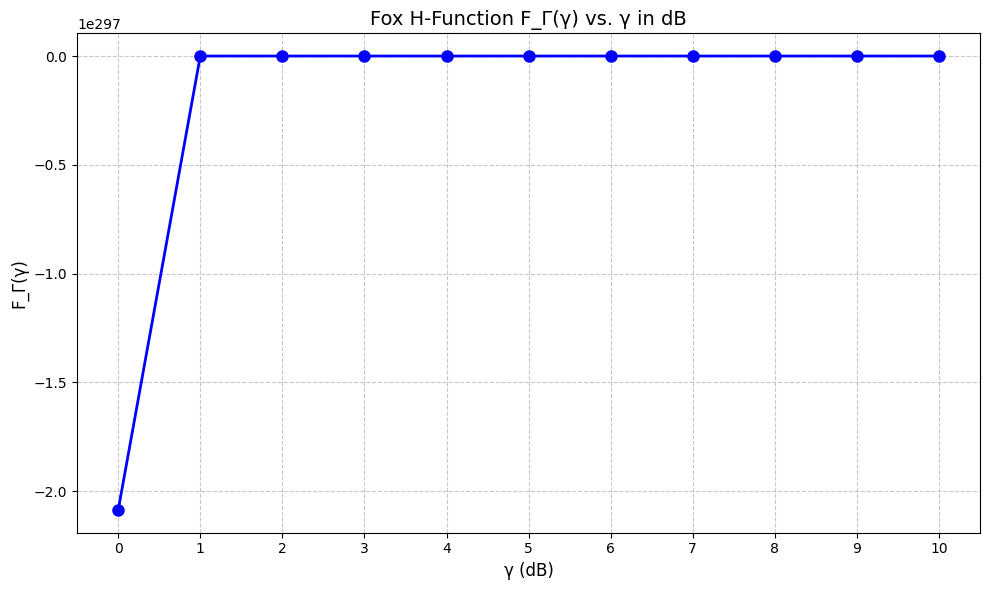

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
import cmath
import mpmath as mp
from functools import lru_cache
import warnings
import matplotlib.pyplot as plt

# Set mpmath precision for numerical stability
mp.mp.dps = 50  # Increase digits of precision significantly
# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def I_Func(an, An, AAn, ap, Ap, AAp, bm, Bm, BBm, bq, Bq, BBq, z, v):
    """
    Python implementation of I_Func for calculating a complex contour integral.
    
    Parameters:
    -----------
    an, An, AAn : arrays
        Parameters for gamma function products
    ap, Ap, AAp : arrays
        Parameters for gamma function products
    bm, Bm, BBm : arrays
        Parameters for gamma function products
    bq, Bq, BBq : arrays
        Parameters for gamma function products
    z : complex
        Complex variable
    v : float
        Parameter to ensure convergence
    
    Returns:
    --------
    out : float
        Result of the contour integral
    """
    
    def GammaProd(p, x, y, X):
        """Calculate product of gamma functions with overflow protection"""
        if len(p) == 0:
            return np.ones_like(X)
        
        # Use mpmath for high precision gamma function calculation
        result = np.ones_like(X, dtype=complex)
        
        for i in range(len(p)):
            try:
                # Use mpmath for high precision calculation
                if isinstance(X, np.ndarray):
                    for j in range(len(X)):
                        arg = complex(p[i] + x[i] * X[j])
                        # Use logarithmic calculation to avoid overflow
                        log_gamma = mp.log(mp.gamma(arg))
                        log_result = y[i] * log_gamma
                        result[j] *= mp.exp(log_result)
                else:
                    arg = complex(p[i] + x[i] * X)
                    log_gamma = mp.log(mp.gamma(arg))
                    log_result = y[i] * log_gamma
                    result *= mp.exp(log_result)
            except (OverflowError, ValueError, ZeroDivisionError):
                # Set to a very small value instead of causing overflow
                if isinstance(X, np.ndarray):
                    result = np.ones_like(X, dtype=complex) * 1e-300
                else:
                    result = 1e-300
        
        return result
    
    def F(s):
        """Integrand function with improved numerical stability"""
        try:
            s = np.atleast_1d(s)
            
            # Calculate parts separately
            num1 = GammaProd(bm, Bm, BBm, s)
            num2 = GammaProd(1 - np.array(an), -np.array(An), AAn, s)
            
            # Handle potential overflow in z**(-s)
            z_term = np.zeros_like(s, dtype=complex)
            for i in range(len(s)):
                # Use mpmath for high precision exponential
                z_term[i] = mp.exp(-s[i] * mp.log(complex(z)))
            
            numerator = num1 * num2 * z_term
            
            denom1 = GammaProd(1 - np.array(bq), -np.array(Bq), BBq, s)
            denom2 = GammaProd(ap, Ap, AAp, s)
            denominator = denom1 * denom2
            
            # Safe division to avoid NaN/Inf
            result = np.zeros_like(s, dtype=complex)
            for i in range(len(s)):
                if abs(denominator[i]) > 1e-300:
                    result[i] = numerator[i] / denominator[i]
                else:
                    result[i] = 0.0
                    
            return result
        except Exception as e:
            # Return zeros for any exception
            if isinstance(s, np.ndarray):
                return np.zeros_like(s, dtype=complex)
            else:
                return 0.0
    
    # Parameters
    p = len(An) + len(Ap)
    q = len(Bm) + len(Bq)
    
    alphaFox = sum(An) - sum(Ap) + sum(Bm) - sum(Bq)
    mu = sum(Bm) + sum(Bq) - sum(An) - sum(Ap)
    
    # Calculate betaFox
    betaFox = 1.0
    for i in range(len(An)):
        betaFox *= (An[i] ** (-An[i]))
    for i in range(len(Ap)):
        betaFox *= (Ap[i] ** (-Ap[i]))
    for i in range(len(Bm)):
        betaFox *= (Bm[i] ** (-Bm[i]))
    for i in range(len(Bq)):
        betaFox *= (Bq[i] ** (-Bq[i]))
    
    delta = sum(bm) + sum(bq) - sum(an) - sum(ap) + (p - q) / 2
    Tol = 1e-5
    
    # Conditions per contour
    # Contour L_(c+i*infinity)
    condition01 = (alphaFox > 0) and (abs(cmath.phase(z)) < np.pi * alphaFox / 2)
    condition02 = (alphaFox == 0) and ((delta * mu + np.real(delta)) < -1) and (cmath.phase(z) == 0)
    condition0 = condition01 or condition02
    
    # Contour L_(-infinity)
    condition11 = (mu > 0) and (z != 0)
    condition12 = (mu == 0) and (abs(z) < betaFox) and (abs(z) > 0)
    condition13 = (mu == 0) and (abs(z) == betaFox) and (np.real(delta) < -1)
    condition1 = condition11 or condition12 or condition13
    
    # Contour L_(+infinity)
    condition21 = (mu < 0) and (z != 0)
    condition22 = (mu == 0) and (abs(z) > betaFox)
    condition2 = condition21 or condition22
    
    # Contour preparation
    epsilon = 10 ** 1.2
    
    # Calculate Sups and Infs
    Sups_values = []
    for i in range(len(an)):
        if An[i] != 0:
            Sups_values.append((v + 1 - an[i]) / An[i])
    
    Infs_values = []
    for i in range(len(bm)):
        if Bm[i] != 0:
            Infs_values.append(-(bm[i] + v) / Bm[i])
    
    if not Sups_values and not Infs_values:
        WPx = 1
    elif not Sups_values and Infs_values:
        WPx = max(Infs_values) + epsilon
    elif Sups_values and not Infs_values:
        WPx = min(Sups_values) - epsilon
    else:
        WPx = (min(Sups_values) + max(Infs_values)) / 2
    
    WayPoints = [complex(WPx, -epsilon), complex(WPx, epsilon)]
    
    # Integration
    if condition0 or (not condition1 and not condition2):
        infinity = 10
        
        def real_imag_integrand(y):
            try:
                result = F(complex(WPx, y))
                return np.real(result), np.imag(result)
            except Exception:
                return 0.0, 0.0
        
        try:
            real_integral, _ = integrate.quad(
                lambda y: real_imag_integrand(y)[0], 
                -infinity, infinity, 
                epsabs=Tol, epsrel=Tol,
                limit=200  # Increase integration points
            )
            
            imag_integral, _ = integrate.quad(
                lambda y: real_imag_integrand(y)[1], 
                -infinity, infinity, 
                epsabs=Tol, epsrel=Tol,
                limit=200  # Increase integration points
            )
            
            out = (1 / (2 * 1j * np.pi)) * complex(real_integral, imag_integral)
            return float(np.real(out))
        except Exception:
            return 0.0
    
    elif condition1:
        try:
            infinity = 100
            if Infs_values:
                infinity = infinity - min(Infs_values)
            
            # Use more points for better precision
            num_points = 2000
            
            # Create a more sophisticated integration path
            t_values = np.linspace(0, 1, num_points)
            points = []
            
            # Start from negative infinity
            start_point = complex(-infinity, 0)
            
            # Create a path to the first waypoint
            for t in t_values:
                points.append(start_point * (1-t) + WayPoints[0] * t)
                
            # Add path between waypoints
            for t in t_values:
                points.append(WayPoints[0] * (1-t) + WayPoints[1] * t)
            
            points = np.array(points)
            
            # Calculate function values and derivatives for path integration
            values = F(points)
            # Calculate differentials along the path
            dz = np.diff(points)
            midpoints = (points[:-1] + points[1:]) / 2
            midvalues = F(midpoints)
            
            # Calculate integral using trapezoidal rule
            integral = np.sum(midvalues * dz)
            
            out = (1 / (2 * 1j * np.pi)) * integral
            return float(np.real(out))
        except Exception:
            return 0.0
    
    elif condition2:
        try:
            infinity = 100
            if Sups_values:
                infinity = infinity + max(Sups_values)
            
            # Use more points for better precision
            num_points = 2000
            
            # Create a more sophisticated integration path
            t_values = np.linspace(0, 1, num_points)
            points = []
            
            # Start from positive infinity
            start_point = complex(infinity, 0)
            
            # Create a path to the first waypoint
            for t in t_values:
                points.append(start_point * (1-t) + WayPoints[0] * t)
                
            # Add path between waypoints
            for t in t_values:
                points.append(WayPoints[0] * (1-t) + WayPoints[1] * t)
                
            points = np.array(points)
            
            # Calculate function values and derivatives for path integration
            values = F(points)
            # Calculate differentials along the path
            dz = np.diff(points)
            midpoints = (points[:-1] + points[1:]) / 2
            midvalues = F(midpoints)
            
            # Calculate integral using trapezoidal rule
            integral = np.sum(midvalues * dz)
            
            out = (1 / (2 * 1j * np.pi)) * integral
            return float(np.real(out))
        except Exception:
            return 0.0

@lru_cache(maxsize=1024)
def R_v_mu(v, mu, x):
    """
    Calculate the R function used in the coefficient a_j computation.
    LRU cache added for performance improvement.
    
    Parameters:
    -----------
    v : float
        v parameter
    mu : float
        mu parameter
    x : float
        x parameter
        
    Returns:
    --------
    float
        R function value
    """
    try:
        # Check if mu is a positive integer
        if (mu > 0) and (mu == int(mu)):
            mu_int = int(mu)  # Convert to integer
            
            # Calculate Pochhammer symbols
            term1 = mp.rf((v - mu)/2, mu_int)  # Rising factorial (Pochhammer symbol)
            term2 = mp.rf((v - mu + 1)/2, mu_int)
            
            # Calculate numerator factor
            num_factor = (term1 * term2 / mp.factorial(mu_int)) * (x**mu_int)
            
            # Calculate hypergeometric function
            hyper = mp.hyper([(v+mu)/2, (v+mu+1)/2], [1+mu], x)
            R_value = num_factor * hyper
        else:
            # Calculate hypergeometric function for non-integer mu
            hyper = mp.hyper([(v - mu)/2, (v - mu + 1)/2], [1 - mu], x)
            R_value = hyper / mp.gamma(1 - mu)
        
        return float(R_value)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

@lru_cache(maxsize=1024)
def compute_a_j(j, m, K, Delta=1):
    """
    Compute the coefficient a_j used in the Fox H-function expansion.
    LRU cache added for performance improvement.
    
    Parameters:
    -----------
    j : int
        Index of coefficient
    m : float
        The m parameter from the system
    K : float
        The K parameter from the system
    Delta : float
        Delta parameter, default is 1
        
    Returns:
    --------
    float
        Coefficient a_j
    """
    try:
        # Calculate argument for R function
        arg2 = ((K * Delta) / (m + K))**2
        
        total_sum = 0
        
        # Loop over k from 0 to j
        for k_ in range(j + 1):
            # Calculate binomial coefficient for j choose k
            cjk = mp.binomial(j, k_)
            inner_sum = 0
            
            # Loop over l from 0 to k
            for l_ in range(k_ + 1):
                gam_fac = j + m + 2*l_ - k_
                ckl = mp.binomial(k_, l_)
                gamma_val = mp.gamma(gam_fac)
                first_factor = ckl * gamma_val
                sec_factor = ((m + K)**(-gam_fac)) * (K**(2*l_ - k_)) * ((Delta/2)**(2*l_))
                power_sign = (-1)**(2*l_ - k_)
                
                v_val = j + m
                mu_val = k_ - 2*l_
                
                # Calculate R function
                R_val = R_v_mu(v_val, mu_val, arg2)
                
                third_factor = power_sign * R_val
                inner_term = first_factor * sec_factor * third_factor
                inner_sum = inner_sum + inner_term
            
            middle_mul = inner_sum * cjk
            total_sum = total_sum + middle_mul
        
        return float(total_sum)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

def calculate_F_gamma(gamma, rho, z, m, sigma, A0, h_t, k, max_j=10):
    """
    Calculate the Fox H-function formula F_Γ(γ) with improved numerical stability.
    
    Parameters:
    -----------
    gamma : float
        The gamma parameter
    rho : float
        The rho parameter
    z : float
        The z parameter
    m : float
        The m parameter
    sigma : float
        The sigma parameter
    A0 : float
        The A0 parameter
    h_t : float
        The h_t parameter
    k : float
        The k parameter
    max_j : int, optional
        Maximum number of terms to sum, default is 10
        
    Returns:
    --------
    float
        The result of the Fox H-function calculation
    """
    try:
        # Convert inputs to mpmath objects for higher precision
        gamma = mp.mpf(gamma)
        rho = mp.mpf(rho)
        z = mp.mpf(z)
        m = mp.mpf(m)
        sigma = mp.mpf(sigma)
        A0 = mp.mpf(A0)
        h_t = mp.mpf(h_t)
        k = mp.mpf(k)
        
        # Calculate gamma_bar
        gamma_bar = 1.0

        # Calculate powers using logarithms to avoid overflow
        rho_sq = rho**2
        
        # Calculate the prefactor in log space
        log_numerator = mp.log(rho_sq) + k * mp.log(z) + m * mp.log(m)
        log_denominator = mp.log(2) + (rho_sq/2) * mp.log(2 * sigma**2 * A0**2 * h_t**2 * gamma_bar) + mp.log(mp.gamma(m))
        log_prefactor = log_numerator - log_denominator
        
        # Convert back from log space
        prefactor = mp.exp(log_prefactor)
        
        # Apply gamma term
        gamma_term = gamma**(rho_sq/2)
        
        # Initialize sum
        fox_sum = mp.mpf(0)
        
        # Calculate sum over j with convergence check
        last_result = mp.mpf(0)
        convergence_threshold = 1e-10
        
        for j in range(max_j + 1):
            # Calculate a_j coefficient (convert to mpmath for higher precision)
            a_j = mp.mpf(compute_a_j(j, float(m), float(k)))
            
            # Calculate K^j / (j!)^2 using logarithms for better numerical stability
            log_K_term = j * mp.log(k) - 2 * mp.log(mp.factorial(j))
            K_term = mp.exp(log_K_term)
            
            # Input value for the H-function (safeguarded)
            if gamma == 0:
                z_val = mp.mpf('1e-300')
            else:
                z_val = gamma / (2 * sigma**2 * A0**2 * h_t**2 * gamma_bar)
                if z_val == 0:
                    z_val = mp.mpf('1e-300')
            
            # Convert to basic Python float for compatibility with I_Func
            z_val = float(z_val)
            
            # Define parameter arrays for I_Func
            an = [float(1-rho_sq/2), float(1+z-rho_sq), 1.0]
            An = [1.0, 2.0, 1.0]
            AAn = [1.0, float(k), 1.0]
            
            ap = [float(j-rho_sq/2+1), 0.0, float(z-rho_sq), float(-rho_sq/2)]
            Ap = [1.0, 1.0, 2.0, 1.0]
            AAp = [1.0, 1.0, float(k), 1.0]
            
            # Empty arrays for bm, bq parameters
            bm = []
            Bm = []
            BBm = []
            
            bq = []
            Bq = []
            BBq = []
            
            # Calculate the Fox H-function using I_Func with error handling
            try:
                fox_value = I_Func(an, An, AAn, ap, Ap, AAp, bm, Bm, BBm, bq, Bq, BBq, z_val, 0.01)
                if np.isnan(fox_value) or np.isinf(fox_value):
                    fox_value = 0.0
            except Exception:
                fox_value = 0.0
            
            # Add term to the sum
            term = a_j * K_term * fox_value
            fox_sum += term
            
            # Check for convergence - if the relative change is small, we can stop
            current_result = prefactor * gamma_term * fox_sum
            if j > 0 and abs(current_result - last_result) < convergence_threshold * abs(last_result):
                break
            last_result = current_result
        
        # Calculate final result
        result = prefactor * gamma_term * fox_sum
        
        # Convert from mpmath to standard float
        result_float = float(result)
        
        # Check for validity
        if np.isnan(result_float) or np.isinf(result_float):
            return 0.0
        
        return result_float
    
    except Exception as e:
        print(f"Error in calculate_F_gamma: {str(e)}")
        return 0.0

def main():
    """
    Main function to calculate F_gamma over a range of gamma values in dB
    and plot the results
    """
    # Example parameters - using moderate values to avoid numerical issues
    rho = 0.3
    z = 1.0
    m = 2.0
    sigma = 0.5
    A0 = 1.0
    h_t = 0.8
    k = 2.0
    max_j = 10
    
    print("Starting calculations with the following parameters:")
    print(f"rho={rho}, z={z}, m={m}, sigma={sigma}, A0={A0}, h_t={h_t}, k={k}")
    
    # Create a range of gamma_db values from 0 to 10 dB with 1 dB spacing
    gamma_db_values = np.arange(0, 11, 1)  # 0, 1, 2, ..., 10 dB
    
    # Convert from dB to linear scale
    gamma_linear_values = 10 ** (gamma_db_values / 10)
    
    print("\nGamma values:")
    for i, (db, linear) in enumerate(zip(gamma_db_values, gamma_linear_values)):
        print(f"  {db} dB = {linear:.4f} (linear)")
    
    # Calculate F_gamma for each value
    f_gamma_results = []
    
    print("\nCalculating F_gamma for each gamma value:")
    for i, (gamma_db, gamma) in enumerate(zip(gamma_db_values, gamma_linear_values)):
        try:
            result = calculate_F_gamma(gamma, rho, z, m, sigma, A0, h_t, k, max_j=max_j)
            f_gamma_results.append(result)
            print(f"  F_gamma({gamma_db} dB) = {result}")
        except Exception as e:
            print(f"  Error calculating F_gamma({gamma_db} dB): {str(e)}")
            f_gamma_results.append(0.0)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(gamma_db_values, f_gamma_results, 'bo-', linewidth=2, markersize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('γ (dB)', fontsize=12)
    plt.ylabel('F_Γ(γ)', fontsize=12)
    plt.title('Fox H-Function F_Γ(γ) vs. γ in dB', fontsize=14)
    plt.xticks(gamma_db_values)
    
    # Add some styling to make the plot more readable
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('F_gamma_vs_gamma_db.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved as 'F_gamma_vs_gamma_db.png'")
    
    return f_gamma_results, gamma_db_values

if __name__ == "__main__":
    main()

Starting calculations with the following parameters:
rho=0.3, z=1.0, m=2.0, sigma=0.5, A0=1.0, h_t=0.8, k=2.0

Gamma values:
  0 dB = 1.0000 (linear)
  1 dB = 1.2589 (linear)
  2 dB = 1.5849 (linear)
  3 dB = 1.9953 (linear)
  4 dB = 2.5119 (linear)
  5 dB = 3.1623 (linear)
  6 dB = 3.9811 (linear)
  7 dB = 5.0119 (linear)
  8 dB = 6.3096 (linear)
  9 dB = 7.9433 (linear)
  10 dB = 10.0000 (linear)

Calculating F_gamma for each gamma value:
  F_gamma(0 dB) = 0.0
  F_gamma(1 dB) = 0.0
  F_gamma(2 dB) = 0.0
  F_gamma(3 dB) = 0.0
  F_gamma(4 dB) = 0.0
  F_gamma(5 dB) = 0.0
  F_gamma(6 dB) = 0.0
  F_gamma(7 dB) = 0.0
  F_gamma(8 dB) = 0.0
  F_gamma(9 dB) = 0.0
  F_gamma(10 dB) = 0.0

Plot saved as 'F_gamma_vs_gamma_db_improved.png'


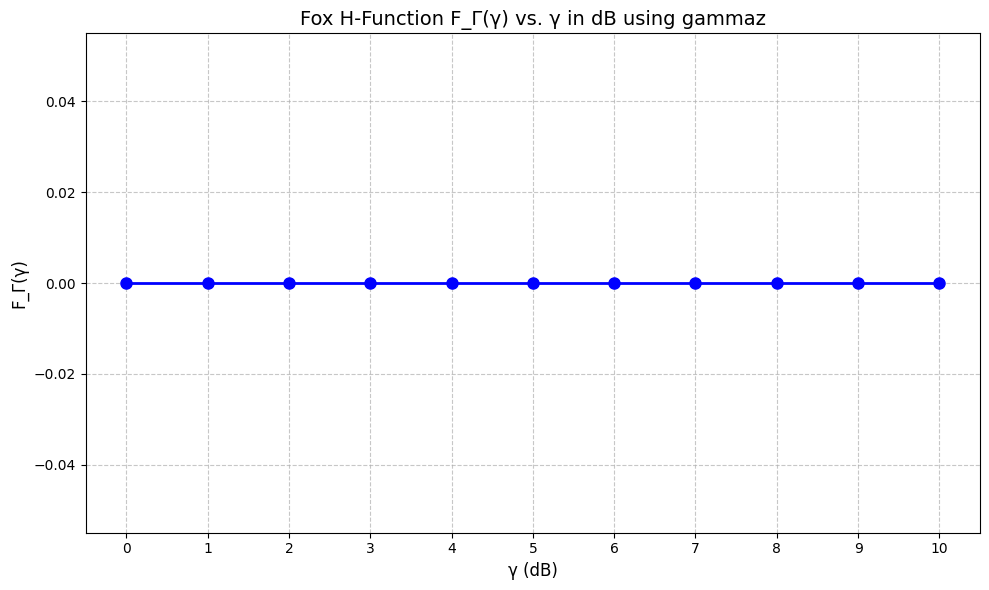

In [2]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
import cmath
import mpmath as mp
from functools import lru_cache
import warnings
import matplotlib.pyplot as plt

# Set mpmath precision for numerical stability
mp.mp.dps = 50
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def gammaz(z):
    """
    Python implementation of the gammaz function for improved numerical stability.
    This is a conversion of the MATLAB gammaz function provided.
    
    Parameters:
    -----------
    z : complex or array of complex
        Input value(s)
        
    Returns:
    --------
    f : complex or array of complex
        Gamma function values
    """
    # Convert inputs to numpy arrays if needed
    is_scalar = np.isscalar(z)
    if is_scalar:
        z = np.array([z], dtype=complex)
    else:
        z = np.array(z, dtype=complex)
    
    # Save original shape and flatten
    original_shape = z.shape
    z = z.flatten()
    zz = z.copy()
    
    # Initialize result array
    f = np.zeros_like(z, dtype=complex)
    
    # Handle negative real parts
    p = np.where(np.real(z) < 0)[0]
    if len(p) > 0:
        z[p] = -z[p]
    
    # Constants for the approximation
    g = 607/128  # best results when 4<=g<=5
    
    # Coefficients (should sum to about g*g/2+23/24)
    c = np.array([
        0.99999999999999709182,
        57.156235665862923517,
        -59.597960355475491248,
        14.136097974741747174,
        -0.49191381609762019978,
        0.33994649984811888699e-4,
        0.46523628927048575665e-4,
        -0.98374475304879564677e-4,
        0.15808870322491248884e-3,
        -0.21026444172410488319e-3,
        0.21743961811521264320e-3,
        -0.16431810653676389022e-3,
        0.84418223983852743293e-4,
        -0.26190838401581408670e-4,
        0.36899182659531622704e-5
    ])
    
    # Main computation
    z = z - 1
    zh = z + 0.5
    zgh = zh + g
    
    # Trick for avoiding FP overflow above z=141
    zp = zgh**(zh * 0.5)
    
    ss = np.zeros_like(z, dtype=complex)
    for pp in range(len(c)-2, -1, -1):
        ss = ss + c[pp+1] / (z + pp)
    
    # sqrt(2Pi)
    sq2pi = 2.5066282746310005024157652848110
    
    f = (sq2pi * (c[0] + ss)) * ((zp * np.exp(-zgh)) * zp)
    
    # Handle special cases
    zero_or_one = np.where((z == 0) | (z == 1))[0]
    if len(zero_or_one) > 0:
        f[zero_or_one] = 1.0
    
    # Adjust for negative real parts
    if len(p) > 0:
        f[p] = -np.pi / (zz[p] * f[p] * np.sin(np.pi * zz[p]))
    
    # Adjust for negative poles
    p = np.where(
        (np.round(zz) == zz) & 
        (np.imag(zz) == 0) & 
        (np.real(zz) <= 0)
    )[0]
    
    if len(p) > 0:
        f[p] = float('inf')
    
    # Reshape and return
    if is_scalar:
        return f[0]
    else:
        return f.reshape(original_shape)

def I_Func(an, An, AAn, ap, Ap, AAp, bm, Bm, BBm, bq, Bq, BBq, z, v):
    """
    Improved Python implementation of I_Func using the gammaz function for
    calculating a complex contour integral.
    
    Parameters:
    -----------
    an, An, AAn : arrays
        Parameters for gamma function products
    ap, Ap, AAp : arrays
        Parameters for gamma function products
    bm, Bm, BBm : arrays
        Parameters for gamma function products
    bq, Bq, BBq : arrays
        Parameters for gamma function products
    z : complex
        Complex variable
    v : float
        Parameter to ensure convergence
    
    Returns:
    --------
    out : float
        Result of the contour integral
    """
    
    def GammaProd(p, x, y, X):
        """Calculate product of gamma functions using gammaz for better stability"""
        if len(p) == 0:
            return np.ones_like(X, dtype=complex)
        
        # Create meshgrid for vectorized computation
        if isinstance(X, (list, np.ndarray)):
            if len(X) > 0:
                PP, XX = np.meshgrid(p, X)
                xx = np.zeros_like(PP, dtype=float)
                for i in range(len(p)):
                    xx[:, i] = X * x[i]
                
                # Calculate gamma products
                gamma_vals = gammaz(PP + xx)
                
                # Apply exponents
                for i in range(len(p)):
                    gamma_vals[:, i] = gamma_vals[:, i] ** y[i]
                
                # Calculate product along axis 1
                output = np.prod(gamma_vals, axis=1)
                return output
            else:
                return np.ones(0, dtype=complex)
        else:
            # Handle scalar X
            result = 1.0
            for i in range(len(p)):
                arg = p[i] + x[i] * X
                gamma_val = gammaz(arg)
                result *= gamma_val ** y[i]
            return np.array([result], dtype=complex)
    
    def F(s):
        """Integrand function using GammaProd with gammaz"""
        numerator = GammaProd(bm, Bm, BBm, s) * GammaProd(1 - np.array(an), -np.array(An), AAn, s)
        
        # Calculate z^(-s) with protection against overflow/underflow
        if isinstance(s, np.ndarray):
            z_term = np.zeros_like(s, dtype=complex)
            for i in range(len(s)):
                try:
                    z_term[i] = z ** (-s[i])
                except (OverflowError, ZeroDivisionError):
                    # Use logarithm for large/small values
                    z_term[i] = np.exp(-s[i] * np.log(complex(z)))
        else:
            try:
                z_term = z ** (-s)
            except (OverflowError, ZeroDivisionError):
                z_term = np.exp(-s * np.log(complex(z)))
        
        numerator = numerator * z_term
        
        denominator = GammaProd(1 - np.array(bq), -np.array(Bq), BBq, s) * GammaProd(ap, Ap, AAp, s)
        
        # Safe division
        if isinstance(s, np.ndarray):
            result = np.zeros_like(s, dtype=complex)
            for i in range(len(s)):
                if abs(denominator[i]) > 1e-300:
                    result[i] = numerator[i] / denominator[i]
                else:
                    result[i] = 0.0
            return result
        else:
            if abs(denominator) > 1e-300:
                return numerator / denominator
            else:
                return 0.0
    
    # Parameters
    p = len(An) + len(Ap)
    q = len(Bm) + len(Bq)
    
    alphaFox = sum(An) - sum(Ap) + sum(Bm) - sum(Bq)
    mu = sum(Bm) + sum(Bq) - sum(An) - sum(Ap)
    
    # Calculate betaFox as in the original MATLAB code
    betaFox = 1.0
    for i in range(len(An)):
        betaFox *= (An[i] ** (-An[i]))
    for i in range(len(Ap)):
        betaFox *= (Ap[i] ** (-Ap[i]))
    for i in range(len(Bm)):
        betaFox *= (Bm[i] ** (-Bm[i]))
    for i in range(len(Bq)):
        betaFox *= (Bq[i] ** (-Bq[i]))
    
    delta = sum(bm) + sum(bq) - sum(an) - sum(ap) + (p - q) / 2
    Tol = 1e-5
    
    # Conditions per contour
    # Contour L_(c+i*infinity)
    condition01 = (alphaFox > 0) and (abs(cmath.phase(z)) < np.pi * alphaFox / 2)
    condition02 = (alphaFox == 0) and ((delta * mu + np.real(delta)) < -1) and (cmath.phase(z) == 0)
    condition0 = condition01 or condition02
    
    # Contour L_(-infinity)
    condition11 = (mu > 0) and (z != 0)
    condition12 = (mu == 0) and (abs(z) < betaFox) and (abs(z) > 0)
    condition13 = (mu == 0) and (abs(z) == betaFox) and (np.real(delta) < -1)
    condition1 = condition11 or condition12 or condition13
    
    # Contour L_(+infinity)
    condition21 = (mu < 0) and (z != 0)
    condition22 = (mu == 0) and (abs(z) > betaFox)
    condition2 = condition21 or condition22
    
    # Contour preparation
    epsilon = 10 ** 1.2
    
    # Calculate Sups and Infs as in the MATLAB code
    Sups_values = []
    for i in range(len(an)):
        if An[i] != 0:
            Sups_values.append((v + 1 - an[i]) / An[i])
    
    Infs_values = []
    for i in range(len(bm)):
        if Bm[i] != 0:
            Infs_values.append(-(bm[i] + v) / Bm[i])
    
    if not Sups_values and not Infs_values:
        WPx = 1
    elif not Sups_values and Infs_values:
        WPx = max(Infs_values) + epsilon
    elif Sups_values and not Infs_values:
        WPx = min(Sups_values) - epsilon
    else:
        WPx = (min(Sups_values) + max(Infs_values)) / 2
    
    WayPoints = [complex(WPx, -epsilon), complex(WPx, epsilon)]
    
    # Integration
    if condition0 or (not condition1 and not condition2):
        infinity = 10
        
        def real_imag_integrand(y):
            try:
                result = F(complex(WPx, y))
                return np.real(result), np.imag(result)
            except Exception:
                return 0.0, 0.0
        
        try:
            real_integral, _ = integrate.quad(
                lambda y: real_imag_integrand(y)[0], 
                -infinity, infinity, 
                epsabs=Tol, epsrel=Tol,
                limit=200
            )
            
            imag_integral, _ = integrate.quad(
                lambda y: real_imag_integrand(y)[1], 
                -infinity, infinity, 
                epsabs=Tol, epsrel=Tol,
                limit=200
            )
            
            out = (1 / (2 * 1j * np.pi)) * complex(real_integral, imag_integral)
            return float(np.real(out))
        except Exception:
            return 0.0
    
    elif condition1:
        try:
            infinity = 100
            if Infs_values:
                infinity = infinity - min(Infs_values)
            
            # Use more points for better precision
            num_points = 1000
            
            # Create a contour path starting from negative infinity
            t_values = np.linspace(0, 1, num_points)
            points = []
            
            # Start from negative infinity
            start_point = complex(-infinity, 0)
            
            # Create a path to the first waypoint
            for t in t_values:
                points.append(start_point * (1-t) + WayPoints[0] * t)
                
            # Add path between waypoints
            for t in t_values:
                points.append(WayPoints[0] * (1-t) + WayPoints[1] * t)
            
            points = np.array(points)
            
            # Calculate function values for path integration
            values = F(points)
            
            # Calculate differentials along the path
            dz = np.diff(points)
            midpoints = (points[:-1] + points[1:]) / 2
            midvalues = F(midpoints)
            
            # Calculate integral using trapezoidal rule
            integral = np.sum(midvalues * dz)
            
            out = (1 / (2 * 1j * np.pi)) * integral
            return float(np.real(out))
        except Exception:
            return 0.0
    
    elif condition2:
        try:
            infinity = 100
            if Sups_values:
                infinity = infinity + max(Sups_values)
            
            # Use more points for better precision
            num_points = 1000
            
            # Create a contour path starting from positive infinity
            t_values = np.linspace(0, 1, num_points)
            points = []
            
            # Start from positive infinity
            start_point = complex(infinity, 0)
            
            # Create a path to the first waypoint
            for t in t_values:
                points.append(start_point * (1-t) + WayPoints[0] * t)
                
            # Add path between waypoints
            for t in t_values:
                points.append(WayPoints[0] * (1-t) + WayPoints[1] * t)
                
            points = np.array(points)
            
            # Calculate function values for path integration
            values = F(points)
            
            # Calculate differentials along the path
            dz = np.diff(points)
            midpoints = (points[:-1] + points[1:]) / 2
            midvalues = F(midpoints)
            
            # Calculate integral using trapezoidal rule
            integral = np.sum(midvalues * dz)
            
            out = (1 / (2 * 1j * np.pi)) * integral
            return float(np.real(out))
        except Exception:
            return 0.0

# The rest of the functions remain the same as in the original code
@lru_cache(maxsize=1024)
def R_v_mu(v, mu, x):
    """
    Calculate the R function used in the coefficient a_j computation.
    LRU cache added for performance improvement.
    
    Parameters:
    -----------
    v : float
        v parameter
    mu : float
        mu parameter
    x : float
        x parameter
        
    Returns:
    --------
    float
        R function value
    """
    try:
        # Check if mu is a positive integer
        if (mu > 0) and (mu == int(mu)):
            mu_int = int(mu)  # Convert to integer
            
            # Calculate Pochhammer symbols
            term1 = mp.rf((v - mu)/2, mu_int)  # Rising factorial (Pochhammer symbol)
            term2 = mp.rf((v - mu + 1)/2, mu_int)
            
            # Calculate numerator factor
            num_factor = (term1 * term2 / mp.factorial(mu_int)) * (x**mu_int)
            
            # Calculate hypergeometric function
            hyper = mp.hyper([(v+mu)/2, (v+mu+1)/2], [1+mu], x)
            R_value = num_factor * hyper
        else:
            # Calculate hypergeometric function for non-integer mu
            hyper = mp.hyper([(v - mu)/2, (v - mu + 1)/2], [1 - mu], x)
            R_value = hyper / mp.gamma(1 - mu)
        
        return float(R_value)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

@lru_cache(maxsize=1024)
def compute_a_j(j, m, K, Delta=1):
    """
    Compute the coefficient a_j used in the Fox H-function expansion.
    LRU cache added for performance improvement.
    
    Parameters:
    -----------
    j : int
        Index of coefficient
    m : float
        The m parameter from the system
    K : float
        The K parameter from the system
    Delta : float
        Delta parameter, default is 1
        
    Returns:
    --------
    float
        Coefficient a_j
    """
    try:
        # Calculate argument for R function
        arg2 = ((K * Delta) / (m + K))**2
        
        total_sum = 0
        
        # Loop over k from 0 to j
        for k_ in range(j + 1):
            # Calculate binomial coefficient for j choose k
            cjk = mp.binomial(j, k_)
            inner_sum = 0
            
            # Loop over l from 0 to k
            for l_ in range(k_ + 1):
                gam_fac = j + m + 2*l_ - k_
                ckl = mp.binomial(k_, l_)
                gamma_val = mp.gamma(gam_fac)
                first_factor = ckl * gamma_val
                sec_factor = ((m + K)**(-gam_fac)) * (K**(2*l_ - k_)) * ((Delta/2)**(2*l_))
                power_sign = (-1)**(2*l_ - k_)
                
                v_val = j + m
                mu_val = k_ - 2*l_
                
                # Calculate R function
                R_val = R_v_mu(v_val, mu_val, arg2)
                
                third_factor = power_sign * R_val
                inner_term = first_factor * sec_factor * third_factor
                inner_sum = inner_sum + inner_term
            
            middle_mul = inner_sum * cjk
            total_sum = total_sum + middle_mul
        
        return float(total_sum)
    except (OverflowError, ValueError, ZeroDivisionError):
        # Return 0 if there's a numerical issue
        return 0.0

def calculate_F_gamma(gamma, rho, z, m, sigma, A0, h_t, k, max_j=10):
    """
    Calculate the Fox H-function formula F_Γ(γ) with improved numerical stability.
    
    Parameters:
    -----------
    gamma : float
        The gamma parameter
    rho : float
        The rho parameter
    z : float
        The z parameter
    m : float
        The m parameter
    sigma : float
        The sigma parameter
    A0 : float
        The A0 parameter
    h_t : float
        The h_t parameter
    k : float
        The k parameter
    max_j : int, optional
        Maximum number of terms to sum, default is 10
        
    Returns:
    --------
    float
        The result of the Fox H-function calculation
    """
    try:
        # Convert inputs to mpmath objects for higher precision
        gamma = mp.mpf(gamma)
        rho = mp.mpf(rho)
        z = mp.mpf(z)
        m = mp.mpf(m)
        sigma = mp.mpf(sigma)
        A0 = mp.mpf(A0)
        h_t = mp.mpf(h_t)
        k = mp.mpf(k)
        
        # Calculate gamma_bar
        gamma_bar = 1.0

        # Calculate powers using logarithms to avoid overflow
        rho_sq = rho**2
        
        # Calculate the prefactor in log space
        log_numerator = mp.log(rho_sq) + k * mp.log(z) + m * mp.log(m)
        log_denominator = mp.log(2) + (rho_sq/2) * mp.log(2 * sigma**2 * A0**2 * h_t**2 * gamma_bar) + mp.log(mp.gamma(m))
        log_prefactor = log_numerator - log_denominator
        
        # Convert back from log space
        prefactor = mp.exp(log_prefactor)
        
        # Apply gamma term
        gamma_term = gamma**(rho_sq/2)
        
        # Initialize sum
        fox_sum = mp.mpf(0)
        
        # Calculate sum over j with convergence check
        last_result = mp.mpf(0)
        convergence_threshold = 1e-10
        
        for j in range(max_j + 1):
            # Calculate a_j coefficient (convert to mpmath for higher precision)
            a_j = mp.mpf(compute_a_j(j, float(m), float(k)))
            
            # Calculate K^j / (j!)^2 using logarithms for better numerical stability
            log_K_term = j * mp.log(k) - 2 * mp.log(mp.factorial(j))
            K_term = mp.exp(log_K_term)
            
            # Input value for the H-function (safeguarded)
            if gamma == 0:
                z_val = mp.mpf('1e-300')
            else:
                z_val = gamma / (2 * sigma**2 * A0**2 * h_t**2 * gamma_bar)
                if z_val == 0:
                    z_val = mp.mpf('1e-300')
            
            # Convert to basic Python float for compatibility with I_Func
            z_val = float(z_val)
            
            # Define parameter arrays for I_Func
            an = [float(1-rho_sq/2), float(1+z-rho_sq), 1.0]
            An = [1.0, 2.0, 1.0]
            AAn = [1.0, float(k), 1.0]
            
            ap = [float(j-rho_sq/2+1), 0.0, float(z-rho_sq), float(-rho_sq/2)]
            Ap = [1.0, 1.0, 2.0, 1.0]
            AAp = [1.0, 1.0, float(k), 1.0]
            
            # Empty arrays for bm, bq parameters
            bm = []
            Bm = []
            BBm = []
            
            bq = []
            Bq = []
            BBq = []
            
            # Calculate the Fox H-function using I_Func with error handling
            try:
                fox_value = I_Func(an, An, AAn, ap, Ap, AAp, bm, Bm, BBm, bq, Bq, BBq, z_val, 0.01)
                if np.isnan(fox_value) or np.isinf(fox_value):
                    fox_value = 0.0
            except Exception:
                fox_value = 0.0
            
            # Add term to the sum
            term = a_j * K_term * fox_value
            fox_sum += term
            
            # Check for convergence - if the relative change is small, we can stop
            current_result = prefactor * gamma_term * fox_sum
            if j > 0 and abs(current_result - last_result) < convergence_threshold * abs(last_result):
                break
            last_result = current_result
        
        # Calculate final result
        result = prefactor * gamma_term * fox_sum
        
        # Convert from mpmath to standard float
        result_float = float(result)
        
        # Check for validity
        if np.isnan(result_float) or np.isinf(result_float):
            return 0.0
        
        return result_float
    
    except Exception as e:
        print(f"Error in calculate_F_gamma: {str(e)}")
        return 0.0

def main():
    """
    Main function to calculate F_gamma over a range of gamma values in dB
    and plot the results
    """
    # Example parameters - using moderate values to avoid numerical issues
    rho = 0.3
    z = 1.0
    m = 2.0
    sigma = 0.5
    A0 = 1.0
    h_t = 0.8
    k = 2.0
    max_j = 10
    
    print("Starting calculations with the following parameters:")
    print(f"rho={rho}, z={z}, m={m}, sigma={sigma}, A0={A0}, h_t={h_t}, k={k}")
    
    # Create a range of gamma_db values from 0 to 10 dB with 1 dB spacing
    gamma_db_values = np.arange(0, 11, 1)  # 0, 1, 2, ..., 10 dB
    
    # Convert from dB to linear scale
    gamma_linear_values = 10 ** (gamma_db_values / 10)
    
    print("\nGamma values:")
    for i, (db, linear) in enumerate(zip(gamma_db_values, gamma_linear_values)):
        print(f"  {db} dB = {linear:.4f} (linear)")
    
    # Calculate F_gamma for each value
    f_gamma_results = []
    
    print("\nCalculating F_gamma for each gamma value:")
    for i, (gamma_db, gamma) in enumerate(zip(gamma_db_values, gamma_linear_values)):
        try:
            result = calculate_F_gamma(gamma, rho, z, m, sigma, A0, h_t, k, max_j=max_j)
            f_gamma_results.append(result)
            print(f"  F_gamma({gamma_db} dB) = {result}")
        except Exception as e:
            print(f"  Error calculating F_gamma({gamma_db} dB): {str(e)}")
            f_gamma_results.append(0.0)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(gamma_db_values, f_gamma_results, 'bo-', linewidth=2, markersize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('γ (dB)', fontsize=12)
    plt.ylabel('F_Γ(γ)', fontsize=12)
    plt.title('Fox H-Function F_Γ(γ) vs. γ in dB using gammaz', fontsize=14)
    plt.xticks(gamma_db_values)
    
    # Add some styling to make the plot more readable
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('F_gamma_vs_gamma_db_improved.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved as 'F_gamma_vs_gamma_db_improved.png'")
    
    return f_gamma_results, gamma_db_values

if __name__ == "__main__":
    main()